# Tucker Decomposition using ALS

In [33]:
import torch
import numpy as np
import tensorly as tl # Used for verification
import matplotlib.pyplot as plt

## Mode-N Matricization

In [34]:
"""
Input:  1) tensor: Input tensor
        2) n: mode along which to matricize the tensor (mode is 0-indexed)
Output: matrix: n-mode matricization of the tensor
"""
# Take mode = 0 for the first mode, mode = 1 for the second mode, ...., mode = n-1 for nth mode
def mode_n_matricization(tensor, n):
    mode = n
    # Get the size of the original tensor
    sz = tensor.size()
    # print(f"tensor size: {sz}")

    # Permute the dimensions of the tensor to bring the chosen mode to the front
    # This will make it easy to reshape the tensor into a matrix along the chosen mode
    permuted_dimensions = list(range(len(sz)))
#     print('Before Permuation, dimensions: ', permuted_dimensions)
    permuted_dimensions.remove(mode)
    permuted_dimensions.insert(0, mode)
#     print('After Permuation, dimensions: ', permuted_dimensions)
    permuted_tensor = tensor.permute(*permuted_dimensions)
#     print(f"permuted tensor size: {permuted_tensor.size()}")

    # Reshape the permuted tensor into a matrix along the chosen mode
    matrix = permuted_tensor.reshape(sz[mode], -1)
#     print(f"matrix size: {matrix.size()}")

#     print(f"n-mode matricization along mode {mode}:")
#     print(matrix)

    return matrix

## Test Mode-N Matricization

In [35]:
my_tensor = torch.empty((2,3,4))
my_tensor[0, :, :] = torch.tensor([[1,4,7,10], [2,5,8,11], [3,6,9,12]])
my_tensor[1, :, :] = torch.tensor([[13,16,19,22], [14,17,20,23], [15,18,21,24]])
print(f"Original Tensor: {my_tensor.size()}")

for n in range(len(my_tensor.size())):
    print(f"\nn-mode matricization along mode {n}:")
    matrix = mode_n_matricization(my_tensor, n)
    print(matrix)

Original Tensor: torch.Size([2, 3, 4])

n-mode matricization along mode 0:
tensor([[ 1.,  4.,  7., 10.,  2.,  5.,  8., 11.,  3.,  6.,  9., 12.],
        [13., 16., 19., 22., 14., 17., 20., 23., 15., 18., 21., 24.]])

n-mode matricization along mode 1:
tensor([[ 1.,  4.,  7., 10., 13., 16., 19., 22.],
        [ 2.,  5.,  8., 11., 14., 17., 20., 23.],
        [ 3.,  6.,  9., 12., 15., 18., 21., 24.]])

n-mode matricization along mode 2:
tensor([[ 1.,  2.,  3., 13., 14., 15.],
        [ 4.,  5.,  6., 16., 17., 18.],
        [ 7.,  8.,  9., 19., 20., 21.],
        [10., 11., 12., 22., 23., 24.]])


## Higher Order Singular Value Decomposition (HOSVD)

In [36]:
"""
Input:  1) X: Input tensor of size (s_1,s_2,...,s_N)
        2) R: array of decomposition ranks of size N (R_1,R_2,...,R_N)
Output: A: array of factor matrices of size N (A_1,A_2,...,A_N)
"""
def HOSVD(X, R):
    N = len(R)
    A = []
    for n in range(N):
        # Matricize the input tensor along the n-th mode
        Xn = mode_n_matricization(X, n)
        # Compute the left singular matrix of the n-th matricization
        U = torch.svd(Xn).U
        # Take the leading R[n] columns of the left singular matrix
        if(R[n] > U.size()[1]):
            Zero = torch.zeros(U.size()[0], R[n] - U.size()[1])
            An = torch.cat((U, Zero), dim=1)
        else:
            An = U[:, :R[n]]
        A.append(An)
    return A  
        

## Einsum functions

In [37]:
"""
Input: T: Input tensor
Output: equation: equation string for torch.einsum()
"""
def einsum_equation(T):
    equation = ''
    for i in range(len(T.size())): 
        equation += f'{chr(97 + i)}'
    for i in range(len(T.size())):
        equation += f',{chr(122 -i)}{chr(97 + i)}'
    equation += '->'
    for i in range(len(T.size())):
        equation += f'{chr(122 - i)}'
    # print(f"equation: {equation}")
    return equation

T = torch.randn((2,3,4,5,6))
eqn = einsum_equation(T)
print(f"equation: {eqn}")

equation: abcde,za,yb,xc,wd,ve->zyxwv


## Test HOSVD

In [38]:
my_tensor = torch.randn((2,3,4,5))
ranks = [1,2,3,4]
print(f"Original Tensor: {my_tensor.size()}")

# Decompose the tensor into a core tensor and factor matrices
A = HOSVD(my_tensor, ranks)
A_T = [A[i].T for i in range(len(A))]
for i in range(len(A)):
    print(f"Factor Matrix {i+1}: {A[i].size()}")

eqn = einsum_equation(my_tensor)
G = torch.einsum(eqn, my_tensor, *A_T)
print(f"Core Tensor: {G.size()}")

# Multiply matrices with core tensor to obtain the original tensor
my_tensor_reconstructed = torch.einsum(eqn, G, *A)

# Reshape the reconstructed tensor to the original size
print(f"Reconstructed Tensor: {my_tensor_reconstructed.size()}")

Original Tensor: torch.Size([2, 3, 4, 5])
Factor Matrix 1: torch.Size([2, 1])
Factor Matrix 2: torch.Size([3, 2])
Factor Matrix 3: torch.Size([4, 3])
Factor Matrix 4: torch.Size([5, 4])
Core Tensor: torch.Size([1, 2, 3, 4])
Reconstructed Tensor: torch.Size([2, 3, 4, 5])


## Higher-Order Orthogonal Iteration (HOOI)

In [39]:
"""
Input:  1) T: Input tensor of size (s_1,s_2,...,s_N)
        2) R: array of decomposition ranks of size N (R_1,R_2,...,R_N)
Output: 1) G: core tensor of size (R_1,R_2,...,R_N)
        2) A: array of factor matrices of size N (A_1,A_2,...,A_N)
"""
def Tucker_ALS(T,R, max_iter=100, tol=1e-20):
    # Initialize the factor matrices with HOSVD
    A = HOSVD(T, R)
    A_T = [A[i].T for i in range(len(A))]

    # Fitness array
    fitness_arr = []
    # Initial fitness
    eqn = einsum_equation(T)
    G = torch.einsum(eqn, T, *A_T)
    fitness = 1 - torch.norm(T - torch.einsum(eqn, G, *A))/torch.norm(T)
    fitness_arr.append(fitness)


    # Iterate until convergence
    for iter in range(max_iter):
        prev_factors = A.copy()

        # Update the factor matrices one by one
        for n in range(len(R)):
            B = A_T.copy()
            B[n] = torch.eye(T.size()[n])
            eqn = einsum_equation(T)
            Y = torch.einsum(eqn, T, *B)

            # Take the leading R[n] columns of the left singular matrix of Yn
            Yn = mode_n_matricization(Y, n)
            U = torch.svd(Yn).U            
            if(R[n] > U.size()[1]):
                Zero = torch.zeros(U.size()[0], R[n] - U.size()[1])
                An = torch.cat((U, Zero), dim=1)
            else:
                An = U[:, :R[n]]

            # Update the factor matrix
            A[n] = An
            A_T[n] = An.T

            # Calculate fitness for each iteration
            G = torch.einsum(eqn, T, *A_T)
            fitness = 1 - torch.norm(T - torch.einsum(eqn, G, *A))/torch.norm(T)
            fitness_arr.append(fitness)

        # Check for convergence
        if all(torch.norm(A[i] - prev_factors[i]) < tol for i in range(T.dim())):
            print(f"Converged at iteration {iter}")
            break
    
    # Compute the core tensor after Tucker decomposition
    G = torch.einsum(eqn, T, *A_T)

    return G, A, fitness_arr           

## Test HOOI

In [40]:
tensor = torch.randn((3,4,5,6))
ranks=[2, 3, 2, 2]
print("Original tensor:")
print(tensor)

"""
Tucker Decomposition using TensorLy
"""
print("Tucker Decomposition using TensorLy:")
# Perform Tucker decomposition
T = tensor.numpy()
core_tensor, factor_matrices =  tl.decomposition.tucker(T, ranks)

# Print the shapes of the core tensor and factor matrices
print("Core Tensor Shape:", core_tensor.shape)
print("Core Tensor:")
print(core_tensor)
for i in range(len(factor_matrices)):
    print("Factor Matrix {} Shape: {}".format(i+1, factor_matrices[i].shape))
    print("Factor Matrix {}: ".format(i+1))
    print(factor_matrices[i])

# Norm difference between original tensor and reconstructed tensor
print("\nNorm difference between original tensor and reconstructed tensor: {}".format(tl.norm(T - tl.tucker_to_tensor((core_tensor, factor_matrices)))))



"""
Tucker Decomposition using Tucker_ALS
"""
print("\nTucker Decomposition using Tucker_ALS:")
G, A, fitness_arr = Tucker_ALS(tensor, ranks)

# Print the resulting core tensor and factor matrices
print("Core tensor Shape:", G.shape)
print('Core tensor:')
print(G)
for n in range(len(ranks)):
    print("\nFactor matrix {} Shape: {}".format(n+1, A[n].shape))
    print(f"Factor matrix {n+1}:")
    print(A[n])

# Norm difference between original tensor and reconstructed tensor
eqn = einsum_equation(tensor)
print(f"\nNorm difference between original tensor and reconstructed tensor: {torch.norm(tensor - torch.einsum(eqn, G, *A))}")



Original tensor:
tensor([[[[-0.3030, -1.0455,  0.3551,  1.1503,  0.8600,  1.7905],
          [ 0.0507, -0.2743, -2.0522, -0.4260, -0.8463,  0.4325],
          [-1.4456, -1.5603,  0.3312, -1.1584, -0.4544, -0.1204],
          [-0.8494,  1.1884,  1.7271, -0.3909,  1.0248, -1.6493],
          [ 0.3690,  0.0719, -0.4639, -0.3966, -0.3502, -1.0950]],

         [[ 2.2207,  0.6184, -0.0572, -1.2159, -0.3148, -1.0553],
          [ 0.3168,  0.0319, -1.0091, -1.5588,  0.1848, -0.9749],
          [ 1.6290,  1.0082, -2.0808,  0.2901, -0.5810,  1.3078],
          [-0.5219,  0.5842, -0.4709,  0.7280,  0.2561, -1.5237],
          [ 2.1864,  1.5032, -1.3021, -0.9245,  0.2596, -0.9945]],

         [[ 0.6005, -0.5164,  1.5570,  1.4029,  1.3255,  0.6522],
          [-0.5318,  1.1184, -0.1358, -0.4140, -0.4660, -0.3630],
          [-0.7636, -1.6910,  2.9302, -1.4625, -1.4315,  0.6952],
          [-0.4807, -1.4361,  0.3355, -0.4504, -1.3361, -1.3941],
          [-0.0997,  0.4363,  1.0124, -0.0462, -0.4746,

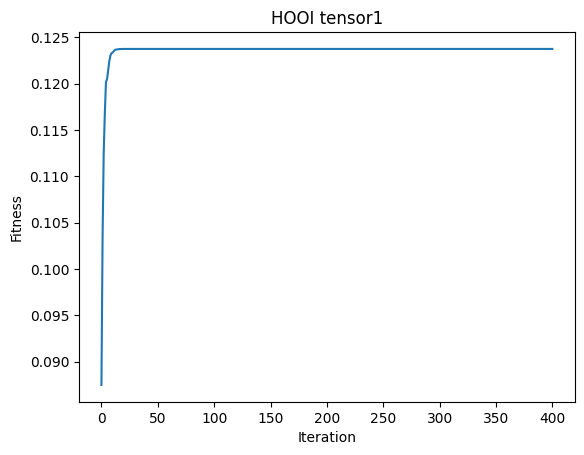

In [41]:
#Now plot
itera=[i for i in range(len(fitness_arr))]
plt.plot(itera, fitness_arr)
plt.xlabel('Iteration')
plt.ylabel('Fitness')
plt.title('HOOI tensor1')
plt.show()

